 **1. Installing Dependencies**

In [ ]:
%pip install pyodbc

In [ ]:
# I used this to install the sql driver: no need to run again.
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/16.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

**2. Importing the libraries**

In [90]:
#Standard libraries
import pyodbc
from sqlalchemy import create_engine
import urllib.parse
import datetime
import pandas as pd
import numpy as np
import math
import random
import time
from collections import Counter

# Tools
from scipy.stats import kurtosis, skew
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Visualizations
from matplotlib import pyplot as plt, ticker as ticker
import seaborn as sns
sns.set(style="whitegrid", rc={'figure.figsize':(15,6)})
%matplotlib inline

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [32]:
#database
server = 'dva-fall22.database.windows.net'
database = 'cse6242'
username = 'admin-dva'
password = '{expert-cranberry-genius-2022}'
driver = '{ODBC Driver 17 for SQL Server}'

**3. Reading data**

In [33]:
#SQL to get all the data from db
dim_test_outcome_query = ''' SELECT * FROM dbo.mdr_test_outcome'''
dim_test_type_query = ''' SELECT * FROM dbo.mdr_test_type'''
dim_fuel_type_query = '''  SELECT * FROM dbo.mdr_fuel_type'''
dim_group_item_query = '''  SELECT DISTINCT id.rfr_id, id.test_class_id, id.rfr_desc, id.rfr_insp_manual_desc, gd.item_name 
                            FROM dbo.item_detail AS id
                            JOIN dbo.group_detail AS gd ON gd.test_class_id = id.test_class_id AND gd.test_item_id = id.test_item_id'''

fact_test_results_query = ''' SELECT * FROM _test_results_2021_formatted_sample_of_1_000_000_rows'''
fact_test_items_query = ''' SELECT * FROM _test_items_of_test_results_2021_formatted_sample_of_1_000_000_rows''' 


In [34]:
#Executing the SQL
with pyodbc.connect(
        'DRIVER=' + driver + ';SERVER=tcp:' + server + ';PORT=1433;DATABASE=' + database + ';UID=' + username + ';PWD=' + password) as conn:
  dim_test_outcome = pd.read_sql(dim_test_outcome_query, conn)
  dim_test_type = pd.read_sql(dim_test_type_query, conn)
  dim_fuel_type = pd.read_sql(dim_fuel_type_query, conn)
  dim_group_item = pd.read_sql(dim_group_item_query, conn)


  fact_test_results = pd.read_sql(fact_test_results_query, conn)
  fact_test_items = pd.read_sql(fact_test_items_query, conn)

**4. EDA & Data Processing**

Haven't merged the Test items table. It contains a couple of features like `test_id`, `rfr_id`, `location_id` etc. which I don't think would be useful in  modelling

In [52]:
#Merging all the tables together to create one single dataframe
fact_results = pd.merge(fact_test_results,dim_test_outcome, left_on = "test_result", right_on = "result_code", how = "inner")
fact_results = pd.merge(fact_results, dim_test_type.add_suffix('_dim'), left_on = "test_type", right_on = "type_code_dim", how = "inner")
fact_results.drop(['test_result', 'result_code','test_type', 'type_code_dim' ], inplace = True, axis = 1)
fact_results = pd.merge(fact_results, dim_fuel_type.add_suffix('_dim'), left_on = "fuel_type", right_on = "type_code_dim", how = "inner")
fact_results.drop([ 'fuel_type', 'type_code_dim' ], inplace = True, axis = 1)

In [36]:
fact_results.shape

(999992, 14)

In [50]:
fact_results.dtypes

test_id                int64
vehicle_id             int64
test_date             object
test_class_id          int64
test_mileage         float64
postcode_area         object
make                  object
model                 object
colour                object
cylinder_capacity    float64
first_use_date        object
result                object
test_type_dim         object
fuel_type_dim         object
dtype: object

In [54]:
# #Regrouping the results into 3 main categories
fact_results['result_grouped'] = fact_results['result'].map({'Passed' : 'Passed', 'Pass with Rectification at Station' : 'Passed', 'Failed' : 'Failed', 'Aborted' : 'Insufficient', 'Abandoned' : 'Insufficient', 'Aborted by VE': 'Insufficient'})

#Vehicle Id is not necessarily needed as the vehicle details can be identified by other features like make, model, colour etc. 
fact_results.drop(columns = ['result', 'vehicle_id'], inplace = True)
fact_results.rename(columns = {'result_grouped' : 'result', 'fuel_type_dim' : 'fuel_type', 'test_type_dim' : 'test_type'}, inplace = True)
fact_results.head()

,test_id,test_date,test_class_id,test_mileage,postcode_area,make,model,colour,cylinder_capacity,first_use_date,test_type,fuel_type,result
0,59,2021-08-21,4,120775.0,SO,MERCEDES-BENZ,C,SILVER,2148.0,2005-11-04,Normal Test,Diesel,Passed
1,171,2021-08-09,4,52073.0,CA,VOLKSWAGEN,TIGUAN,GREY,1968.0,2015-10-17,Normal Test,Diesel,Passed
2,193,2021-02-12,4,100119.0,PR,AUDI,A4,BLUE,1968.0,2008-11-19,Normal Test,Diesel,Passed
3,261,2021-12-06,4,86455.0,ST,LAND ROVER,DISCOVERY,BLUE,2495.0,2004-07-26,Normal Test,Diesel,Passed
4,283,2021-07-26,4,24737.0,DN,FIAT,DUCATO,WHITE,2287.0,2007-09-04,Normal Test,Diesel,Passed


In [55]:
#Calculating Vehicle Age 
fact_results['test_date'] = pd.to_datetime(fact_results.test_date,  format='%Y-%m-%d')
fact_results['first_use_date'] = pd.to_datetime(fact_results.first_use_date,  format='%Y-%m-%d')

#Dropping the rows where test_date is before the first_use_date as this scenario is not possible & incorrect
fact_results = fact_results[fact_results.test_date >= fact_results.first_use_date]

fact_results['Age'] = fact_results.test_date - fact_results.first_use_date
fact_results['Age'] = fact_results.Age.dt.days

fact_results.drop(columns = ['test_date', 'first_use_date'], inplace = True)

In [56]:
fact_results.head()

,test_id,test_class_id,test_mileage,postcode_area,make,model,colour,cylinder_capacity,test_type,fuel_type,result,Age
0,59,4,120775.0,SO,MERCEDES-BENZ,C,SILVER,2148.0,Normal Test,Diesel,Passed,5769
1,171,4,52073.0,CA,VOLKSWAGEN,TIGUAN,GREY,1968.0,Normal Test,Diesel,Passed,2123
2,193,4,100119.0,PR,AUDI,A4,BLUE,1968.0,Normal Test,Diesel,Passed,4468
3,261,4,86455.0,ST,LAND ROVER,DISCOVERY,BLUE,2495.0,Normal Test,Diesel,Passed,6342
4,283,4,24737.0,DN,FIAT,DUCATO,WHITE,2287.0,Normal Test,Diesel,Passed,5074


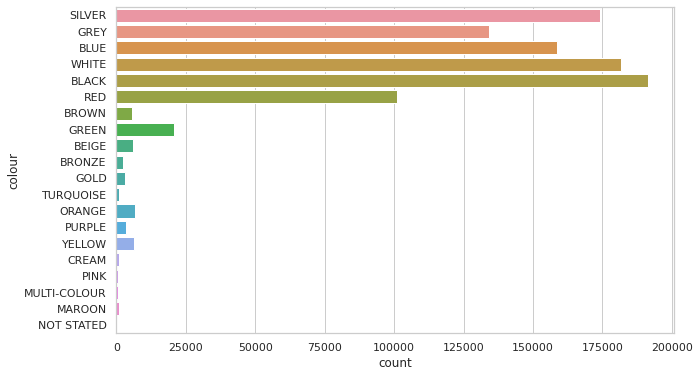

In [57]:
plt.figure(figsize=(10,6))
sns.countplot(y=fact_results.colour)

In [58]:
#Replacing the colurs with value "Not STATED" to the one that's most frequently used 
fact_results['colour'] = np.where(fact_results.colour == "NOT STATED", fact_results.colour.mode()[0], fact_results.colour)

In [59]:
fact_results.result.value_counts()

Passed          804686
Failed          189493
Insufficient      5617
Name: result, dtype: int64

Since we have a very small % of records with Insufficient results, we will drop these & continue the analysis with conclusive results only

In [60]:
fact_results = fact_results[fact_results.result != 'Insufficient']

<Figure size 720x648 with 0 Axes>

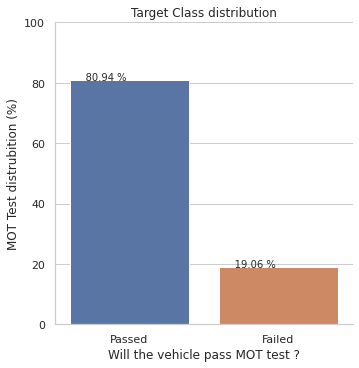

In [61]:
df_class = (fact_results.result.value_counts(normalize=True)*100.0).rename('%').reset_index()
plt.figure(figsize=(10,9))
f = sns.catplot(x='index', y='%', data=df_class, kind='bar')
f.ax.set_ylim(0,100)
for p in f.ax.patches:
    f.ax.text(p.get_x(), p.get_height(), " "*5 + str(round(p.get_height(), 3)) + ' %')
plt.title("Target Class distribution")
plt.xlabel("Will the vehicle pass MOT test ?")
plt.ylabel("MOT Test distrubition (%)")
plt.show()


In [62]:
#Checking for missing values in the entire dataframe
fact_results.isna().sum()

test_id              0
test_class_id        0
test_mileage         0
postcode_area        0
make                 0
model                0
colour               0
cylinder_capacity    0
test_type            0
fuel_type            0
result               0
Age                  0
dtype: int64

In [63]:
fact_results.Age.describe()

count    994179.000000
mean       3635.851993
std        2019.894800
min           0.000000
25%        2098.000000
50%        3291.000000
75%        4902.000000
max       34223.000000
Name: Age, dtype: float64

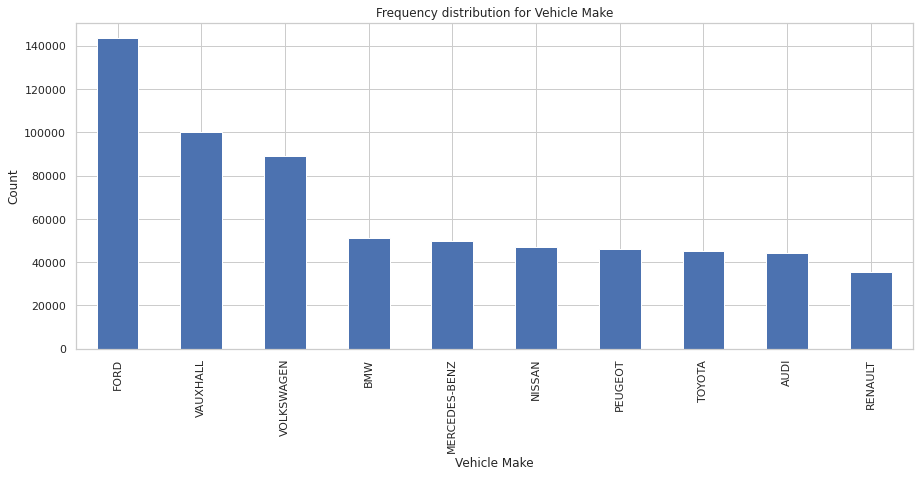

In [64]:
# Top 10 Vehicle Make - Overall
plt.figure(figsize=(15,6))
fact_results.make.value_counts()[:10].plot(kind='bar')  # top 10 models
plt.xlabel("Vehicle Make")
plt.ylabel("Count")
plt.title("Frequency distribution for Vehicle Make")
plt.show()

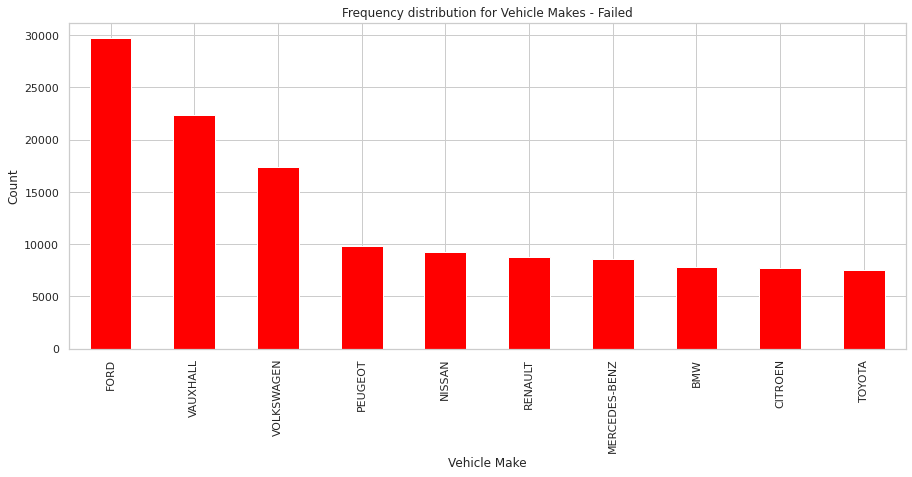

In [65]:
# Top 10 models - Failed 
plt.figure(figsize=(15,6))
fact_results.loc[fact_results.result == "Failed", 'make'].value_counts()[:10].plot(kind='bar', color = 'red')  # top 10 models
plt.xlabel("Vehicle Make")
plt.ylabel("Count")
plt.title("Frequency distribution for Vehicle Makes - Failed")
plt.show()

Its interesting to note that even though **Audi** was in the list of top 10 vehicle makes, it doesn't show up in the top 10 list with highest failure

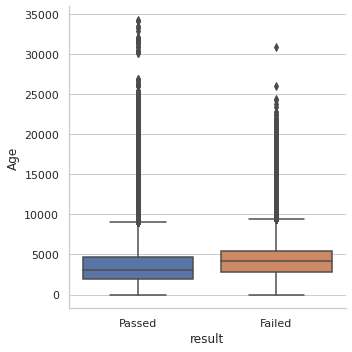

In [67]:
sns.catplot(data=fact_results, x="result", y="Age", kind = 'box')

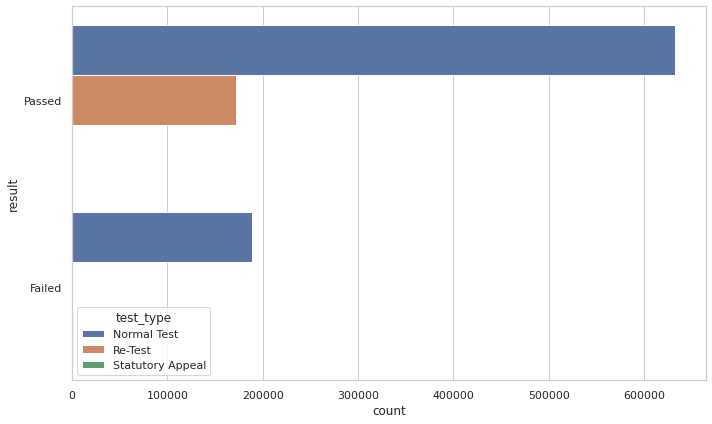

In [ ]:
#Explore Test Type feature 
plt.figure(figsize=(10,6))
sns.countplot(data = fact_results, y=fact_results.result, hue = "test_type")

In [69]:
fact_results.test_type.value_counts()

Normal Test         821772
Re-Test             172404
Statutory Appeal         3
Name: test_type, dtype: int64

In [71]:
#There are only 3 Statutory Appeal test cases. We can eliminate these records from our dataset to restrict the test type to 2 main categories only
fact_results = fact_results[fact_results.test_type != 'Statutory Appeal']

In [72]:
fact_results.head()

,test_id,test_class_id,test_mileage,postcode_area,make,model,colour,cylinder_capacity,test_type,fuel_type,result,Age
0,59,4,120775.0,SO,MERCEDES-BENZ,C,SILVER,2148.0,Normal Test,Diesel,Passed,5769
1,171,4,52073.0,CA,VOLKSWAGEN,TIGUAN,GREY,1968.0,Normal Test,Diesel,Passed,2123
2,193,4,100119.0,PR,AUDI,A4,BLUE,1968.0,Normal Test,Diesel,Passed,4468
3,261,4,86455.0,ST,LAND ROVER,DISCOVERY,BLUE,2495.0,Normal Test,Diesel,Passed,6342
4,283,4,24737.0,DN,FIAT,DUCATO,WHITE,2287.0,Normal Test,Diesel,Passed,5074


In [ ]:
#Pseudo code for exporting a dataframe to csv
# from google.colab import files
# pd.DataFrame(fact_results.make.unique()).to_csv('df.csv')
# files.download('df.csv')

#Pseudo Code for cleaning "MAKE" feature
# make_df = pd.DataFrame(fact_results.make.drop_duplicates())
# make_df['temp_make'] = make_df.make
# #make_df = make_df['temp_make'].str.split('-',expand=True)
# final = make_df.assign(**make_df.temp_make.str.split(' ',expand=True).add_prefix('Make_'))
# final.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Encoding**

In [91]:
#Converting all categorical variables to numerical 
categorical = ['postcode_area', 'make','model', 'colour', 'test_type', 'fuel_type', 'result']
for col in categorical:
    le = preprocessing.LabelEncoder()
    fact_results[col] = le.fit_transform( fact_results[col])
   

Key callouts from HeatMap below -

1.   Result doesn't have a strong correlation to any other features
2.   We can safely drop `test_id` & `test_class_id` as they dont have strong correlation to any features and don't signify anything about the data
3. `test_mileage` and `Age` have a strong correlation. This makes sense as vehicles with higher age will be the ones that have travelled more 



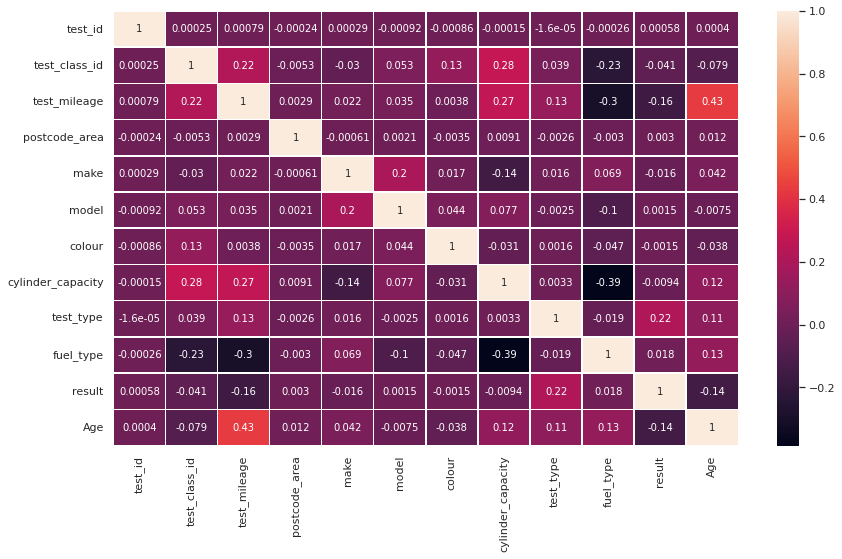

In [96]:
#Checking the correlation of numerical features
fig, ax = plt.subplots(figsize=(14,8))         
sns.heatmap(fact_results.corr(), annot=True, linewidths=.5, ax=ax)

In [98]:
fact_results.drop(columns = ['test_id', 'test_class_id'], inplace = True)